## Stock Price Forecasting via Azure AutoML


In [3]:
#Configuration
import azureml.core
import requests
from alpha_vantage.techindicators import TechIndicators
from alpha_vantage.timeseries import TimeSeries
from azure.storage.blob import BlobServiceClient, BlobClient, ContainerClient, __version__
import os
import uuid
from io import StringIO
from dotenv import load_dotenv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

print("This notebook was created using version 1.19.0 of the Azure ML SDK")
print("You are currently using version", azureml.core.VERSION, "of the Azure ML SDK")

This notebook was created using version 1.19.0 of the Azure ML SDK
You are currently using version 1.1.5 of the Azure ML SDK


In [4]:
pip show azureml.core

Name: azureml-core
Version: 1.1.5.7
Summary: UNKNOWN
Home-page: https://docs.microsoft.com/en-us/azure/machine-learning/service/
Author: Microsoft Corp
Author-email: None
License: https://aka.ms/azureml-sdk-license
Location: c:\users\jason\appdata\local\programs\python\python39\lib\site-packages
Requires: ruamel.yaml, azure-mgmt-resource, cryptography, six, pathspec, azure-mgmt-authorization, python-dateutil, msrest, azure-common, azure-mgmt-keyvault, ndg-httpsclient, requests, pytz, docker, contextlib2, PyJWT, pyopenssl, backports.tempfile, msrestazure, adal, jsonpickle, azure-graphrbac, azure-mgmt-storage, jmespath, azure-mgmt-containerregistry, urllib3, SecretStorage
Required-by: azureml-train-core, azureml-telemetry
Note: you may need to restart the kernel to use updated packages.


In [5]:
#This is a proposed method of reading data straight from blob without downloading it.
conn_str = "FILL IN YOUR OWN"
container = "FILL IN YOUR OWN"
blob_name = "MSFT.csv"
forecast_blob_name = "MSFT_forecast.csv"

container_client = ContainerClient.from_connection_string(
    conn_str=conn_str, 
    container_name=container
    )
# Download blob as StorageStreamDownloader object (stored in memory)
downloaded_blob = container_client.download_blob(blob_name)
downloaded_forecast_blob = container_client.download_blob(forecast_blob_name)
df = pd.read_csv(StringIO(downloaded_blob.content_as_text()))
df_forecast = pd.read_csv(StringIO(downloaded_forecast_blob.content_as_text()))

In [6]:
df_forecast.shape

(30, 6)

                     1. open   2. high  3. low  4. close  5. volume
date                                                               
2020-12-16 05:00:00   214.40  214.5000  214.40    214.50     3030.0
2020-12-16 06:00:00   214.32  214.3200  214.18    214.22     2773.0
2020-12-16 07:00:00   214.31  215.1000  214.30    215.01    22605.0
2020-12-16 08:00:00   215.00  215.0000  214.64    214.80    20088.0
2020-12-16 09:00:00   214.83  214.9690  213.60    214.50    39878.0
...                      ...       ...     ...       ...        ...
2021-02-10 16:00:00   243.33  243.7763  242.23    242.81  3166730.0
2021-02-10 17:00:00   242.82  243.4000  242.56    242.85  1362627.0
2021-02-10 18:00:00   242.90  243.1000  242.74    242.75     5351.0
2021-02-10 19:00:00   242.68  242.9300  242.45    242.53     5471.0
2021-02-10 20:00:00   242.54  242.5400  241.85    241.89    12812.0

[601 rows x 5 columns]
                          SMA
date                         
2020-12-21 16:00:00  218.5511
20

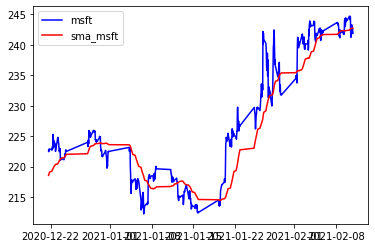

In [7]:

# Importing hidden API Key.
load_dotenv()

# You might need your own API Key, can get for free online.
api_key = os.getenv("API_KEY")



ts = TimeSeries(key = api_key, output_format = "pandas")
data, meta_data = ts.get_intraday(symbol='MSFT',interval='60min', outputsize='full')
data.sort_index(ascending = True, inplace = True)
print(data)

ti = TechIndicators(key = api_key, output_format = 'pandas')
sma, sma_data = ti.get_sma(symbol='MSFT', interval='60min', time_period='60')
sma.sort_index(ascending = True, inplace = True)
print(sma)

agg = data.join(sma, on = "date")
agg.dropna(inplace = True)
print(agg)


ser1 = pd.Series(data['4. close'])
ser2 = pd.Series(sma['SMA'])
ser3 = pd.Series(data.reset_index()['date'])

fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.plot(agg.index, agg["4. close"], c='b', label='msft')
ax1.plot(agg.index, agg["SMA"], c='r', label='sma_msft')
plt.legend(loc='upper left');
plt.show()

In [8]:
#This function is used to pull stock price data from blob based on a ticker
# it will return the stock price and the meta data in two separate data frames.
def get_stock_price(ticker):
    #Create the blob container client
    container_client = ContainerClient.from_connection_string(
    conn_str=conn_str, 
    container_name=container
    )
    
    #Pull and read from blob directly
    stockprice_blob = container_client.download_blob(ticker + ".csv")
    stockpricemeta_blob = container_client.download_blob(ticker + "_meta.csv")
    
    #Convert blob content into dataframe using pandas
    stockprice_df = pd.read_csv(StringIO(stockprice_blob.content_as_text()))
    stockpricemeta_df = pd.read_csv(StringIO(stockpricemeta_blob.content_as_text()))
    
    return stockprice_df, stockpricemeta_df



In [9]:
# Using this dictionary to keep track of the most updated endpoints for each stock
import requests
import json

# Currently ensembles
curr_endpoint_dict = {
    "NIO": "http://d189e1d1-21ea-41d7-97e0-7986f1631c56.eastus2.azurecontainer.io/score",
    "MSFT": "http://beba49eb-2877-4d6a-9ee2-3c2c1c1d05f2.eastus2.azurecontainer.io/score"
}



# This converts the forecast dataframe to a json HTTP request
def generate_request(df_forecast):
    size = df_forecast.shape[0]
    data = []
    for i in range(size):
        info = df_forecast.iloc[i]
        date = info["date"]
        open_price = info["open"]
        high = info["high"]
        low = info["low"]
        close = info["close"]
        volume = info["volume"]
        iter_dict = {"high": high, "open": open_price, "low": low, "volume": volume, "date": date}
        data.append(iter_dict)
    print(data)
    out = {"data": data}
    return out

# This generates the forecast using the request above and the request endpoint
def generate_forecast(ticker):
    # Pull from blob first
    conn_str = "DefaultEndpointsProtocol=https;AccountName=stockforecast;AccountKey=WCohD87qvmtwWYXqSakG1rqw8mLt1sEh9wZGZPussGXarQcUtu99icM4M5CDpPZX6fXuZDCpGU83NIyZHGGeBg==;EndpointSuffix=core.windows.net"
    container = "stockpricetest"
    blob_name = ticker + "_test.csv"
    forecast_blob_name = ticker + "_forecast.csv"
    
    container_client = ContainerClient.from_connection_string(
        conn_str=conn_str, 
        container_name=container
        )
    # Download blob as StorageStreamDownloader object (stored in memory)
    downloaded_blob = container_client.download_blob(blob_name)
    downloaded_forecast_blob = container_client.download_blob(forecast_blob_name)
    df = pd.read_csv(StringIO(downloaded_blob.content_as_text()))
    df_forecast = pd.read_csv(StringIO(downloaded_forecast_blob.content_as_text()))
    endpoint = curr_endpoint_dict[ticker]
    out = requests.post(endpoint, json = generate_request(df)).content
    return out, df_forecast

In [10]:
nio_forecast, nio_shell = generate_forecast("NIO")

[{'high': 47.1299, 'open': 46.88, 'low': 45.35, 'volume': 60582516.0, 'date': '2020-12-24'}, {'high': 48.36, 'open': 47.48, 'low': 45.81, 'volume': 81247871.0, 'date': '2020-12-23'}, {'high': 49.84, 'open': 49.61, 'low': 46.53, 'volume': 117428420.0, 'date': '2020-12-22'}, {'high': 49.49, 'open': 45.63, 'low': 45.02, 'volume': 132558077.0, 'date': '2020-12-21'}, {'high': 48.0, 'open': 45.89, 'low': 45.52, 'volume': 126251125.0, 'date': '2020-12-18'}, {'high': 46.05, 'open': 45.17, 'low': 43.895, 'volume': 130003721.0, 'date': '2020-12-17'}, {'high': 45.26, 'open': 44.25, 'low': 43.33, 'volume': 120109589.0, 'date': '2020-12-16'}, {'high': 43.84, 'open': 42.47, 'low': 41.27, 'volume': 132336854.0, 'date': '2020-12-15'}, {'high': 41.48, 'open': 39.94, 'low': 39.51, 'volume': 171598161.0, 'date': '2020-12-14'}, {'high': 43.63, 'open': 42.48, 'low': 41.26, 'volume': 147076119.0, 'date': '2020-12-11'}, {'high': 45.67, 'open': 42.44, 'low': 41.89, 'volume': 107376836.0, 'date': '2020-12-10'}

In [11]:
nio_forecast

b'"{\\"forecast\\": [49.491947247036364, 49.60790982644969, 49.374751452037124, 49.22924000053791, 49.01204901346393, 48.826585527179766, 48.90601082890899, 48.67949319320074, 48.359164348432344, 48.23698397906192, 48.50513926699155, 48.364272788288694, 48.34711277984866, 48.17227205521909, 47.704601367830165, 48.0148084562016, 47.91131299081426, 47.53336836590761, 47.426060671904985, 47.515050116350544, 47.45185025242577, 47.03460038168412, 47.24932802946309, 46.86842332919263, 46.83534616392601, 46.689499729899, 46.534808730578085, 46.66414734487494, 46.576040337215574, 47.40277144701413], \\"index\\": [{\\"date\\": 1608768000000, \\"_automl_dummy_grain_col\\": \\"_automl_dummy_grain_col\\"}, {\\"date\\": 1608681600000, \\"_automl_dummy_grain_col\\": \\"_automl_dummy_grain_col\\"}, {\\"date\\": 1608595200000, \\"_automl_dummy_grain_col\\": \\"_automl_dummy_grain_col\\"}, {\\"date\\": 1608508800000, \\"_automl_dummy_grain_col\\": \\"_automl_dummy_grain_col\\"}, {\\"date\\": 1608249600

In [12]:
nio_forecast_result = pd.read_csv("NIO_forecast.csv")
nio_forecast_result["predicted"] = [49.491947247036364, 49.60790982644969, 49.374751452037124, 49.22924000053791, 49.01204901346393, 48.826585527179766, 48.90601082890899, 48.67949319320074, 48.359164348432344, 48.23698397906192, 48.50513926699155, 48.364272788288694, 48.34711277984866, 48.17227205521909, 47.704601367830165, 48.0148084562016, 47.91131299081426, 47.53336836590761, 47.426060671904985, 47.515050116350544, 47.45185025242577, 47.03460038168412, 47.24932802946309, 46.86842332919263, 46.83534616392601, 46.689499729899, 46.534808730578085, 46.66414734487494, 46.576040337215574, 47.40277144701413]
nio_forecast_result.iloc[:30]


,date,open,high,low,close,volume,predicted
0,2021-02-09,58.95,63.1000,58.2400,62.84,96407230.0,49.491947
1,2021-02-08,57.08,59.5200,56.1800,59.07,64264889.0,49.607910
2,2021-02-05,57.74,57.9800,56.0100,56.67,43057521.0,49.374751
3,2021-02-04,58.79,59.1994,57.1100,57.60,48667912.0,49.229240
4,2021-02-03,55.96,58.7200,54.8400,57.98,80122323.0,49.012049
5,2021-02-02,57.06,57.5400,54.5100,55.77,65568667.0,48.826586
6,2021-02-01,59.07,59.1200,54.3700,56.99,79878684.0,48.906011
7,2021-01-29,59.03,60.7100,56.4400,57.00,78678189.0,48.679493
8,2021-01-28,56.76,59.4600,55.1500,58.37,73955136.0,48.359164
9,2021-01-27,57.95,59.7900,56.6000,57.15,73078254.0,48.236984


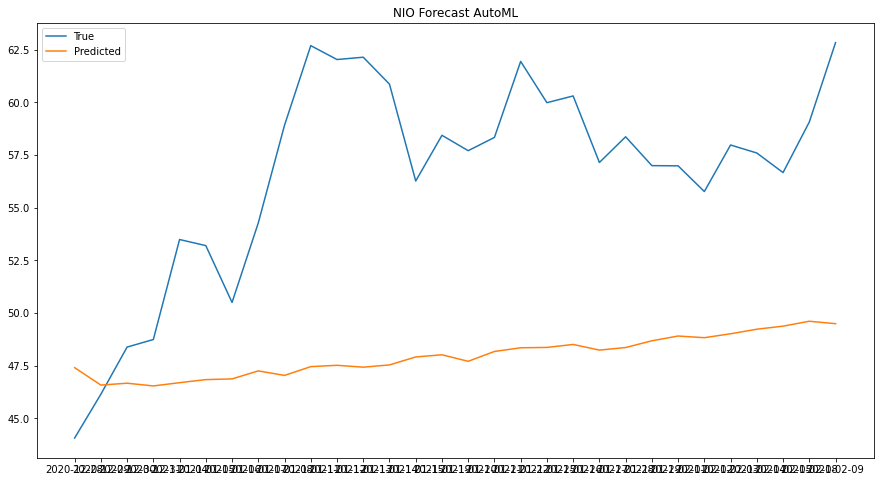

In [13]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 8))
plt.plot(nio_forecast_result['date'][::-1], nio_forecast_result['close'][::-1], label = "True")
plt.plot(nio_forecast_result['date'][::-1], nio_forecast_result['predicted'][::-1], label = "Predicted")
plt.legend()
plt.title("NIO Forecast AutoML")

plt.show()

In [14]:
msft_forecast, msft_shell = generate_forecast("MSFT")

[{'high': 223.61, 'open': 221.42, 'low': 221.2, 'volume': 10550572.0, 'date': '2020-12-24'}, {'high': 223.5589, 'open': 223.11, 'low': 220.8, 'volume': 18699638.0, 'date': '2020-12-23'}, {'high': 225.63, 'open': 222.69, 'low': 221.85, 'volume': 22643397.0, 'date': '2020-12-22'}, {'high': 224.0, 'open': 217.55, 'low': 217.2801, 'volume': 37181886.0, 'date': '2020-12-21'}, {'high': 219.69, 'open': 218.59, 'low': 216.02, 'volume': 63354922.0, 'date': '2020-12-18'}, {'high': 220.89, 'open': 219.87, 'low': 217.92, 'volume': 32515784.0, 'date': '2020-12-17'}, {'high': 220.11, 'open': 214.75, 'low': 214.72, 'volume': 35023253.0, 'date': '2020-12-16'}, {'high': 215.42, 'open': 215.165, 'low': 212.24, 'volume': 27018106.0, 'date': '2020-12-15'}, {'high': 216.21, 'open': 213.1, 'low': 212.88, 'volume': 28798379.0, 'date': '2020-12-14'}, {'high': 213.32, 'open': 210.05, 'low': 209.11, 'volume': 30979440.0, 'date': '2020-12-11'}, {'high': 213.08, 'open': 211.77, 'low': 210.36, 'volume': 26467017.0

In [15]:
msft_forecast

b'"{\\"forecast\\": [222.90908230537786, 222.8810620935614, 223.34706816324223, 222.9924866474391, 221.95851702828162, 222.18835552627905, 222.02126329054616, 220.94749465691274, 221.13050289200973, 220.39973088633008, 220.32718482532962, 220.7826938126302, 221.1681440836169, 220.84225294048906, 220.724309607357, 220.93024108569568, 220.71604430672733, 221.1288382811309, 220.36705873211105, 220.6180570606993, 220.37522449588835, 220.1543925247255, 219.69079113880628, 219.83214615545845, 219.75300968855817, 220.23469239900672, 220.76393484417298, 220.7933453481173, 220.6194539899194, 220.96221267056967], \\"index\\": [{\\"date\\": 1608768000000, \\"_automl_dummy_grain_col\\": \\"_automl_dummy_grain_col\\"}, {\\"date\\": 1608681600000, \\"_automl_dummy_grain_col\\": \\"_automl_dummy_grain_col\\"}, {\\"date\\": 1608595200000, \\"_automl_dummy_grain_col\\": \\"_automl_dummy_grain_col\\"}, {\\"date\\": 1608508800000, \\"_automl_dummy_grain_col\\": \\"_automl_dummy_grain_col\\"}, {\\"date\\"

In [16]:
msft_forecast_result = pd.read_csv("MSFT_forecast.csv")
msft_forecast_result["predicted"] = [222.90908230537786, 222.8810620935614, 223.34706816324223, 222.9924866474391, 221.95851702828162, 222.18835552627905, 222.02126329054616, 220.94749465691274, 221.13050289200973, 220.39973088633008, 220.32718482532962, 220.7826938126302, 221.1681440836169, 220.84225294048906, 220.724309607357, 220.93024108569568, 220.71604430672733, 221.1288382811309, 220.36705873211105, 220.6180570606993, 220.37522449588835, 220.1543925247255, 219.69079113880628, 219.83214615545845, 219.75300968855817, 220.23469239900672, 220.76393484417298, 220.7933453481173, 220.6194539899194, 220.96221267056967]
msft_forecast_result.iloc[:30]

,date,open,high,low,close,volume,predicted
0,2021-02-09,241.87,244.7600,241.3800,243.77,23471475.0,222.909082
1,2021-02-08,243.15,243.6800,240.8100,242.47,22211929.0,222.881062
2,2021-02-05,242.23,243.2800,240.4200,242.20,18054752.0,223.347068
3,2021-02-04,242.66,243.2399,240.3700,242.01,25296100.0,222.992487
4,2021-02-03,239.57,245.0900,239.2600,243.00,27158104.0,221.958517
5,2021-02-02,241.30,242.3100,238.6900,239.51,25678356.0,222.188356
6,2021-02-01,235.06,242.5000,232.4300,239.65,33314193.0,222.021263
7,2021-01-29,235.99,238.0200,231.3500,231.96,42503138.0,220.947495
8,2021-01-28,235.61,242.6400,235.0900,238.93,49111159.0,221.130503
9,2021-01-27,238.00,240.4400,230.1400,232.90,69870638.0,220.399731


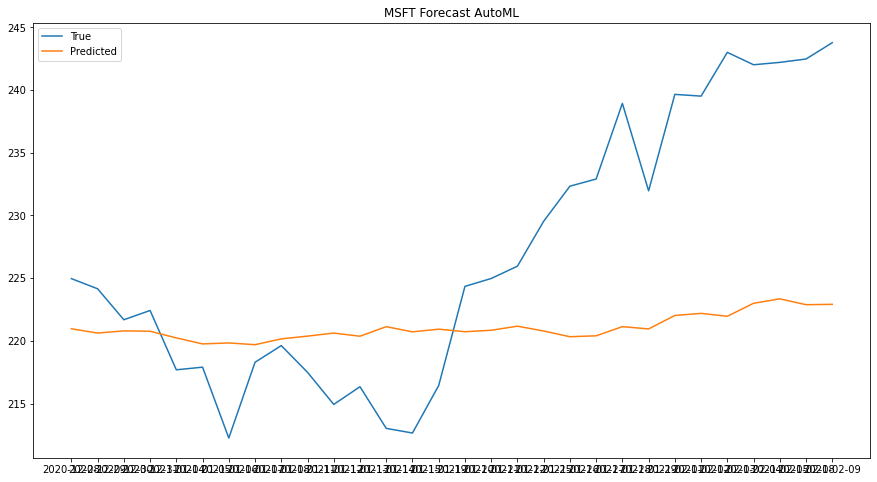

In [17]:
plt.figure(figsize=(15, 8))
plt.plot(msft_forecast_result['date'][::-1], msft_forecast_result['close'][::-1], label = "True")
plt.plot(msft_forecast_result['date'][::-1], msft_forecast_result['predicted'][::-1], label = "Predicted")
plt.legend()
plt.title("MSFT Forecast AutoML")

plt.show()